# INFO 3401 – Class 19: Temporal data analysis review

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning objectives
This lecture will introduce forecasting, one of the most common data analysis tasks when working with time series data.

* Review content about temporal structure, additive models, and autocorrelation
* Using the statsmodels and prophet libraries to forecast temporal data
* Making and interpreting forecasts using DIA, BEST, and other time series data

## Week outline

* **Monday** - Review concepts from last week's classes
* **Wednesday** - Start to use regression for forecasting with temporal data
* **Friday** - More advanced regression feature engineering and using prophet library

## Background

Last week we covered many different functions, methods, and attributes for working with temporal data in pandas and finding common patterns in temporal data. This week we will use this knowledge to make forecasts of what the future using historical data, apply different forecasting methods and tools, and evaluate the performance of forecasts.

## Load libraries

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

## Load data

In [3]:
# Read in the data
den_pass_df = pd.read_csv('den_passengers.csv',index_col=0)

# Cast the index to periods
den_pass_df.index = pd.period_range(den_pass_df.index[0],den_pass_df.index[-1],freq='M')

# Inspect
print(den_pass_df.shape)
den_pass_df.tail(10)

(307, 7)


,American,Delta,Frontier,Other,Southwest,United Express,United
2019-11,248838,271136,645543,269124,1502102.0,653590,1713647
2019-12,285504,312654,558746,306029,1661202.0,749165,1915520
2020-01,252609,277318,527185,282431,1407678.0,685777,1765230
2020-02,236439,263292,493984,258516,1306590.0,694512,1655042
2020-03,146987,150119,306420,147830,770226.0,438251,963524
2020-04,25272,14773,29753,8748,89035.0,41679,89838
2020-05,48289,28214,144702,14486,320493.0,120265,158422
2020-06,74928,48656,323277,45765,809923.0,197807,250012
2020-07,154607,81130,479485,148904,945160.0,294247,488744
2020-08,171353,105907,533026,136293,951646.0,339484,747851


## Clean and explore data
Add up the monthly passenger numbers to a "Total" column.

In [9]:
den_pass_df['Total'] = den_pass_df.sum(axis=1)

den_pass_df.head()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total
1995-02,5833,4805,1434,8625,NaN,2635,47230,70562.0
1995-03,228196,200964,36703,245171,NaN,169190,1962445,2842669.0
1995-04,184229,157853,40050,191393,NaN,124351,1724836,2422712.0
1995-05,187990,162622,41403,171425,NaN,135800,1833305,2532545.0
1995-06,229348,198499,43754,186030,NaN,170033,1975754,2803418.0


Visualize the "Total" column. Add in some annotations for discontinuities.

Text(2020-04, 1000000.0, 'COVID-19 pandemic')

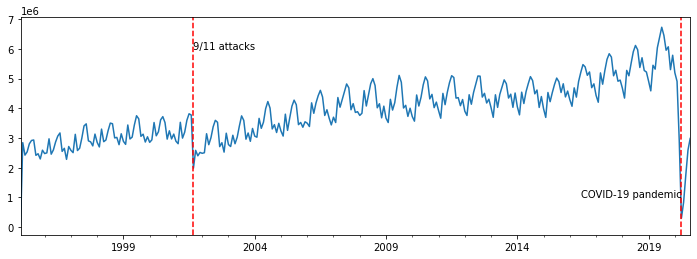

In [74]:
f,ax = plt.subplots(figsize=(12,4))

den_pass_df['Total'].plot(ax=ax)

# Add 9-11
ax.axvline(pd.Period('2001-09'),c='r',ls='--')
ax.text(pd.Period('2001-09'),6e6,'9/11 attacks')

# Add COVID-19 shutdowns
ax.axvline(pd.Period('2020-04'),c='r',ls='--')
ax.text(pd.Period('2020-04'),1e6,'COVID-19 pandemic',ha='right')

Make a rolling 12-month average for the "Total" and save as "Rolling Total".

In [25]:
den_pass_df['Total'].head(20)

1995-02      70562.0
1995-03    2842669.0
1995-04    2422712.0
1995-05    2532545.0
1995-06    2803418.0
1995-07    2917049.0
1995-08    2933160.0
1995-09    2415564.0
1995-10    2469394.0
1995-11    2293523.0
1995-12    2589163.0
1996-01    2475317.0
1996-02    2499223.0
1996-03    2972450.0
1996-04    2455026.0
1996-05    2599531.0
1996-06    2865403.0
1996-07    3064468.0
1996-08    3170296.0
1996-09    2548674.0
Freq: M, Name: Total, dtype: float64

In [28]:
den_pass_df['Rolling Total'] = den_pass_df['Total'].rolling(12).mean()

den_pass_df.tail()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total
2020-04,25272,14773,29753,8748,89035.0,41679,89838,299098.0,5.172371e+06
2020-05,48289,28214,144702,14486,320493.0,120265,158422,834871.0,4.738468e+06
2020-06,74928,48656,323277,45765,809923.0,197807,250012,1750368.0,4.352193e+06
2020-07,154607,81130,479485,148904,945160.0,294247,488744,2592277.0,4.007159e+06
2020-08,171353,105907,533026,136293,951646.0,339484,747851,2985560.0,3.718033e+06


Visualize the "Rolling Total" and the "Total" on the same figure.

<AxesSubplot:>

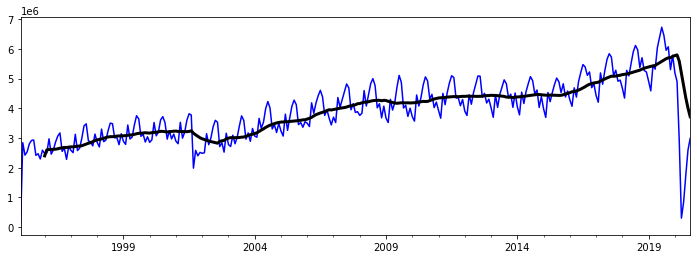

In [31]:
f,ax = plt.subplots(figsize=(12,4))

den_pass_df['Total'].plot(ax=ax,c='b')

den_pass_df['Rolling Total'].plot(ax=ax,c='k',lw=3)

## Describing temporal structure

Review the kinds of temporal structures we can find in this monthly-level data.

### VIsualization
Extract the month from the index and make a new column.

In [35]:
den_pass_df['Month'] = [i.month for i in den_pass_df.index]
den_pass_df.head()

,American,Delta,Frontier,Other,Southwest,United Express,United,Total,Rolling Total,Month
1995-02,5833,4805,1434,8625,NaN,2635,47230,70562.0,NaN,2
1995-03,228196,200964,36703,245171,NaN,169190,1962445,2842669.0,NaN,3
1995-04,184229,157853,40050,191393,NaN,124351,1724836,2422712.0,NaN,4
1995-05,187990,162622,41403,171425,NaN,135800,1833305,2532545.0,NaN,5
1995-06,229348,198499,43754,186030,NaN,170033,1975754,2803418.0,NaN,6


Make a seaborn [pointplot](https://seaborn.pydata.org/generated/seaborn.pointplot.html) with the month on the x-axis and the total number of passengers on the y-axis.

<AxesSubplot:xlabel='Month', ylabel='Total'>

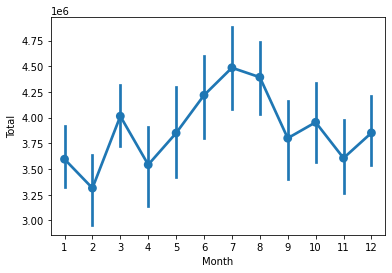

In [38]:
sb.pointplot(x='Month',y='Total',data=den_pass_df)

Interpret the resulting distribution of monthly passenger numbers.

Use a Grouper object to re-sample the data to an annual frequency and aggregate on the "Total" column.

In [41]:
annual_den_pass_total = den_pass_df.groupby(pd.Grouper(freq='1Y')).agg({'Total':'sum'})

annual_den_pass_total

,Total
1995,26289759.0
1996,32296174.0
1997,34969837.0
1998,36831400.0
1999,38034017.0
2000,38751687.0
2001,36092806.0
2002,35652084.0
2003,37505267.0
2004,42271793.0


Make a bar plot of the result.

<AxesSubplot:>

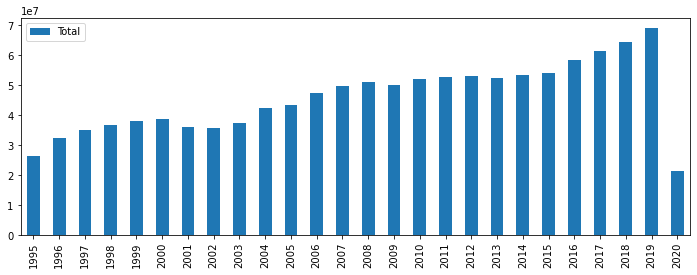

In [43]:
annual_den_pass_total.plot.bar(figsize=(12,4))

Interpret annual trend of passenger numbers.

### Additive models
Use statsmodels's [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function to generate an additive model of the "Total" column.

In [55]:
den_pass_df['Total'].index = den_pass_df['Total'].index.to_timestamp()

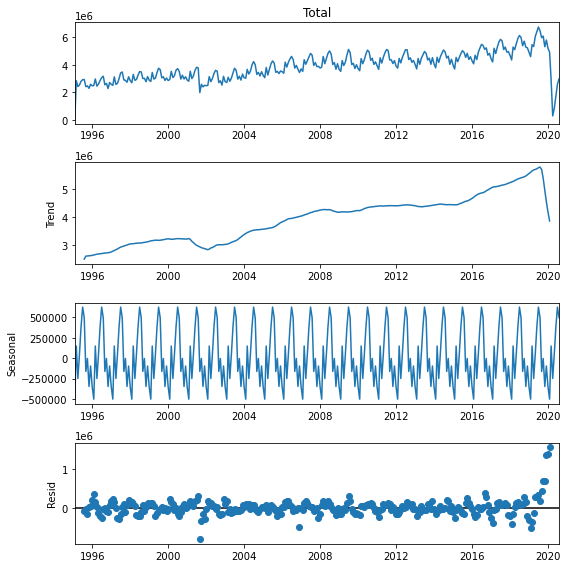

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

dc = seasonal_decompose(den_pass_df['Total'])

# f,ax = plt.subplot(figsize=(12,10))
p = dc.plot()


Interpret the results.

### Autocorrelation

Use either pandas's [`plotting.autocorrelation_plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html) or statsmodel's [`.plot_acf()`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) functions to visualize the autocorrelation in the "Total" time series.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

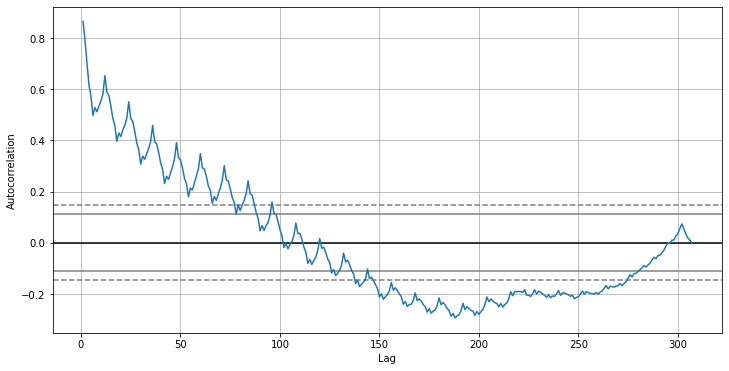

In [68]:
f,ax=plt.subplots(figsize=(12,6))
pd.plotting.autocorrelation_plot(den_pass_df['Total'],ax=ax)

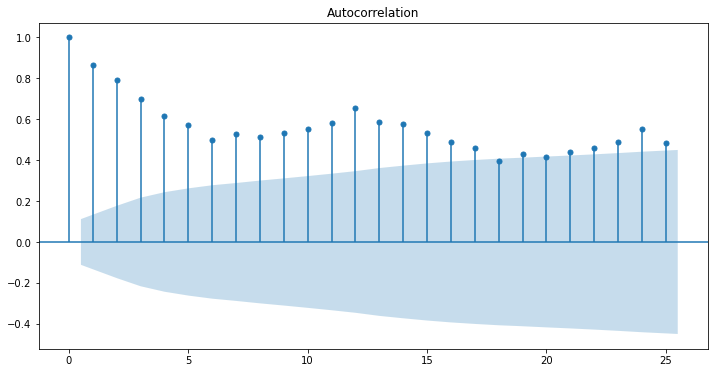

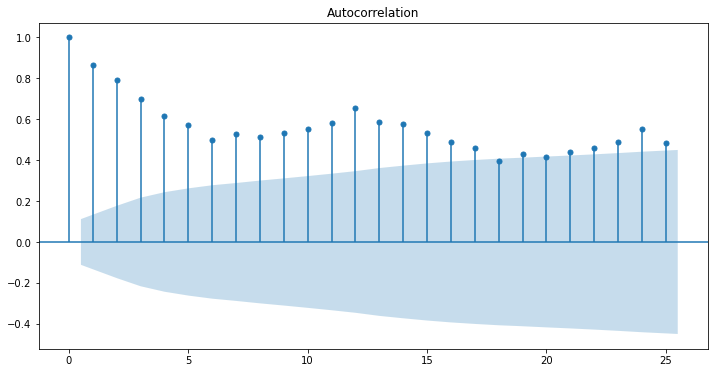

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

f,ax=plt.subplots(figsize=(12,6))
plot_acf(den_pass_df['Total'],ax=ax)

Interpret the results.

## Exercise

Describe the temporal structures in the Berkeley Earth Surface Temperature data.

### Visualization

Extract the month from the index and make a new column.

Make a seaborn [pointplot](https://seaborn.pydata.org/generated/seaborn.pointplot.html) with the month on the x-axis and the 1M temperature anomaly on the y-axis.

Interpret the resulting distribution of monthly temperature anomalies.

Use a Grouper object to re-sample the data to an annual frequency and aggregate to the mean 1M anomaly for each year.

Make a bar plot of the result. You will likely need a wider figsize.

Interpret the annual trend of temperature anomalies.

### Additive models

Use statsmodels's [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function to generate an additive model of the "1M anomaly" column.

Make a 12-month rolling average column from the "1M anomaly" column. Compare to another relevant column.

Plot the 12-month rolling average.

Interpret the results.

### Autocorrelation

Use either pandas's [`plotting.autocorrelation_plot()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html) or statsmodel's [`.plot_acf()`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) functions to visualize the autocorrelation in the "1M anomaly" column.

## Appendix

### Cleaning DEN passenger data

Ben Marwitz at DIA shared the DEN passenger reports with Brian with data from February 1995 through August 2020.

In [ ]:
den_pass_raw_df = pd.read_excel('DEN passengers 1995-2020.xlsx',sheet_name='Passenger',header=[0,1],index_col=0)

# Convert index to monthly period
den_pass_raw_df.index = pd.period_range(den_pass_raw_df.index[0],den_pass_raw_df.index[-1],freq='M')

# Clean up multi-indexed columns to only have totals
total_cols = [c for c in den_pass_raw_df.columns.levels[0] if ' Total' in c]
den_pass_totals_df = den_pass_raw_df[total_cols].copy()
den_pass_totals_df.columns = den_pass_totals_df.columns.droplevel(1)
den_pass_totals_df.drop(columns=['Grand Total','Cargo Total'],inplace=True)

# Take "Total" out of the column names
den_pass_totals_df.columns = [c.replace(' Total','') for c in den_pass_totals_df.columns]

den_pass_totals_df.to_csv('den_passengers.csv',encoding='utf8')
den_pass_totals_df.head()


In [ ]:
ax = den_totals_df.plot(figsize=(8,4))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))
ax.set_ylim((1e4,1e7))
ax.set_yscale('log')